### Import Packages

In [1]:
import collections
import datetime
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

### Define Functions

In [2]:
def get_random_boost_probs(boost_values = list(range(0,50,5)), intercept_range = [0.4, 0.55], supplier_name = ''):
    """
    Generate random acceptance probabilities given a range of boost values
    that follow a 2nd order polynomial pattern
    Args:
        boost_values (list): list of dollar values used in boost
        intercept_range (list): lower and upper bounds to use for b0 intercept
        supplier_name (str): name of simulated supplier
    Returns:
        pandas.DataFrame object with fields 'boost_dollars', 'accept_prob', and 'supplier'
    """
    b0 = random.choice(np.linspace(intercept_range[0], intercept_range[1], 100))
    max_b1 = ((1 - b0) / max(boost_values))
    b1 = random.choice(np.linspace(0, max_b1, 100))
    max_b2 = (1 - (b0 + (b1 * max(boost_values)))) / max(boost_values)**2
    b2 = random.choice(np.linspace(0, max_b2, 100))
    probs = []
    for x in boost_values:
        p = b0 + (b1 * x) + (b2 * x**2)
        probs.append(p)
    output_df = pd.DataFrame({'boost_dollars' : boost_values, 'accept_prob' : probs})
    output_df['supplier'] = supplier_name
    return output_df


def get_random_supplier_info(supplier_names, base_cost_range = [80, 130]):
    """
    Generate a pandas.DataFrame object with costs in a given range and eta probabilities
    0 to 1 representing the likelihood of completing service in under 45 minutes
    Args:
        supplier_names (list): list of supplier names
        base_cost_range (list): minimum and maximum baseline cost for each supplier
    Returns:
        pandas.DataFrame object with fields 'supplier', 'base_cost', 'eta_prob'
    """
    eta_probs = [random.choice(np.linspace(0,1,100)) for i in range(len(supplier_names))]
    base_cost = [random.choice(np.linspace(base_cost_range[0], base_cost_range[1], 100)) for i in range(len(supplier_names))]
    output_df = pd.DataFrame({'supplier' : supplier_names, 'base_cost' : base_cost, 'eta_prob' : eta_probs})
    return output_df


### Generate (Artificial) Supplier & Boost Data

##### Define Supplier Cost and Likelihood of < 45 minute service at each boost level

In [3]:
suppliers = ['Supplier A', 'Supplier B', 'Supplier C']
boost_prob_df = pd.concat([get_random_boost_probs(supplier_name = s) for s in suppliers], axis = 0)
supplier_info_df = get_random_supplier_info(supplier_names = suppliers)
supplier_boost_info_df = pd.merge(supplier_info_df, boost_prob_df, on = 'supplier', how = 'left')
supplier_boost_info_df['total_cost'] = supplier_boost_info_df['base_cost'] + supplier_boost_info_df['boost_dollars']

#### Visualize supplier acceptance likelihood based on boost dollars

Text(0.5, 0, 'Boost Dollars')

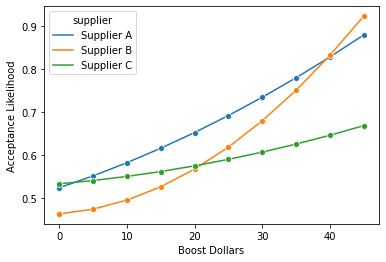

In [4]:
sns.lineplot(x = 'boost_dollars', y = 'accept_prob', hue = 'supplier', marker = 'o',  data = boost_prob_df)
plt.ylabel('Acceptance Likelihood')
plt.xlabel('Boost Dollars')

#### Create eta per dollar measure

In [5]:
supplier_boost_info_df['eta_per_dollar'] = supplier_boost_info_df['eta_prob'] / supplier_boost_info_df['total_cost']

### Use Simulations to Determine How Much to Offer #1 Supplier Based on Conditional Outcomes

Constraints & Assumptions:
- Supplier/Boost combinations are initially ranked by (ETA probability / total cost)
- You can only make each supplier a single offer
- If a supplier does not accept the offer, you move to the next most preferred supplier
- If that supplier does not accept, you move to the next, and so on ...


Challenge is to define the following:
- How much do you offer the first preferred supplier? (avg. simulated eta / avg. simulated cost)
- If that supplier declines, how much do you offer the second most preferred, etc.
- ... to maximize ETA per dollar

##### Simulate outcomes for rank ordered choices at each boost level

In [6]:
supplier_ranking = supplier_boost_info_df.sort_values('eta_per_dollar', ascending = False)
rank_ordered_suppliers = list(pd.unique(supplier_ranking['supplier']))
supplier_ranking.head(10)

,supplier,base_cost,eta_prob,boost_dollars,accept_prob,total_cost,eta_per_dollar
0,Supplier A,84.040404,0.505051,0,0.524242,84.040404,0.006010
1,Supplier A,84.040404,0.505051,5,0.551875,89.040404,0.005672
2,Supplier A,84.040404,0.505051,10,0.582443,94.040404,0.005371
3,Supplier A,84.040404,0.505051,15,0.615949,99.040404,0.005099
4,Supplier A,84.040404,0.505051,20,0.652390,104.040404,0.004854
5,Supplier A,84.040404,0.505051,25,0.691768,109.040404,0.004632
6,Supplier A,84.040404,0.505051,30,0.734083,114.040404,0.004429
7,Supplier A,84.040404,0.505051,35,0.779334,119.040404,0.004243
8,Supplier A,84.040404,0.505051,40,0.827522,124.040404,0.004072
9,Supplier A,84.040404,0.505051,45,0.878646,129.040404,0.003914


In [7]:
rank_ordered_suppliers

['Supplier A', 'Supplier C', 'Supplier B']

##### Run simulation

In [8]:
def run_simulation(dframe, ordered_list, accept_col = 'accept_prob',
                   boost_col = 'boost_dollars', sort_col = 'eta_per_dollar', supplier_col = 'supplier',
                   outcome_cols = ['supplier', 'base_cost', 'boost_dollars', 'total_cost', 'eta_prob']):
    
    dframe_copy = dframe.copy().sort_values(sort_col, ascending = False)
    remaining_suppliers = ordered_list.copy()
    boost_amounts = sorted(list(set(dframe_copy[boost_col])))
    
    
    i = 0
    outcome_list = []
    # Iterate over boost amounts
    for bamt in boost_amounts:
        sub_df = dframe_copy[(dframe_copy[supplier_col] == ordered_list[i]) & (dframe_copy[boost_col] == bamt)]
        prob = list(sub_df[accept_col])[0]
        
        # Simulate supplier decision
        accept = random.choice(np.linspace(0,1,1000)) < prob
        if accept:
            outcome_df = sub_df[outcome_cols]
            outcome_df['decision'] = 'accept'
            outcome_list.append(outcome_df)
            break
        else:
            outcome_df = sub_df[outcome_cols]
            outcome_df['decision'] = 'decline'
            outcome_list.append(outcome_df)
            sub_df = dframe_copy[(dframe_copy[supplier_col] == ordered_list[i+1]) & (dframe_copy[boost_col] == bamt)]
            prob = list(sub_df[accept_col])[0]
            # Simulate supplier decision
            accept = random.choice(np.linspace(0,1,1000)) < prob
            if accept:
                outcome_df = sub_df[outcome_cols]
                outcome_df['decision'] = 'accept'
                outcome_list.append(outcome_df)
                break
            else:
                outcome_df = sub_df[outcome_cols]
                outcome_df['decision'] = 'decline'
                outcome_list.append(outcome_df)
                sub_df = dframe_copy[(dframe_copy[supplier_col] == ordered_list[i+2]) & (dframe_copy[boost_col] == bamt)]
                prob = list(sub_df[accept_col])[0]
                # Simulate supplier decision
                accept = random.choice(np.linspace(0,1,1000)) < prob
                if accept:
                    outcome_df = sub_df[outcome_cols]
                    outcome_df['decision'] = 'accept'
                    outcome_list.append(outcome_df)
                    break
                else:
                    outcome_df = sub_df[outcome_cols]
                    outcome_df['decision'] = 'decline'
                    outcome_list.append(outcome_df)
        
    
    master_outcome_df = pd.concat(outcome_list, axis = 0)
    return master_outcome_df

In [9]:
n_sim = 100
simulation_list = []    

for i in range(1, (n_sim + 1)):
    simulation_df = run_simulation(dframe = supplier_ranking, ordered_list = rank_ordered_suppliers)
    simulation_df['simulation_number'] = i
    simulation_list.append(simulation_df)

master_simulation_df = pd.concat(simulation_list, axis = 0)

### Look at a few simulations

In [10]:
master_simulation_df[master_simulation_df.simulation_number == 1]

,supplier,base_cost,boost_dollars,total_cost,eta_prob,decision,simulation_number
0,Supplier A,84.040404,0,84.040404,0.505051,accept,1


In [11]:
master_simulation_df[master_simulation_df.simulation_number == 2]

,supplier,base_cost,boost_dollars,total_cost,eta_prob,decision,simulation_number
0,Supplier A,84.040404,0,84.040404,0.505051,accept,2


In [12]:
master_simulation_df[master_simulation_df.simulation_number == 3]

,supplier,base_cost,boost_dollars,total_cost,eta_prob,decision,simulation_number
0,Supplier A,84.040404,0,84.040404,0.505051,accept,3


In [13]:
master_simulation_df[master_simulation_df.simulation_number == 4]

,supplier,base_cost,boost_dollars,total_cost,eta_prob,decision,simulation_number
0,Supplier A,84.040404,0,84.040404,0.505051,accept,4


In [14]:
master_simulation_df[master_simulation_df.simulation_number == 5]

,supplier,base_cost,boost_dollars,total_cost,eta_prob,decision,simulation_number
0,Supplier A,84.040404,0,84.040404,0.505051,decline,5
20,Supplier C,117.373737,0,117.373737,0.444444,decline,5
10,Supplier B,89.090909,0,89.090909,0.191919,accept,5


### Next Steps / Thoughts
- Using reinforcement learning or some type of optimization makes sense rather than simulating
- More importantly, defining the objective function to minimize should be a priority (I used probability of arriving within 45 minutes divided by total cost, but we need to give this some thought)